In [1]:
import os
import textwrap
import random
import json
import time
import multiprocessing as mp
from os.path import join
import grape
import algorithms
from EvalTree import EvalKnapSackTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [26]:
# # Genrate a random knapsack
# def gen_knapsack(n_items, value_range, weight_range, out_file):
#     items = {i: {"value": random.randint(
#         *value_range), "weight": random.randint(*weight_range)} for i in range(1, n_items+1)}

#     with open(out_file, 'w') as file:
#         json.dump(items, file)

#     print(f"Data written in file at path: {join(os.getcwd(), out_file)}")

# gen_knapsack(n_items=100, value_range=(1, 50), weight_range=(1, 100), out_file='./tests/knapsackWeights.json')


In [2]:

# load saved weights
meta_file_path = './tests/knapsackWeights.json'
with open(meta_file_path) as file:
    items = json.load(file)['meta']


sum_weights = 0
sum_values = 0
for item in items:
    sum_values += items[item]["value"]
    sum_weights += items[item]["weight"]

print(sum_values, sum_weights)


808 1539


In [3]:

# fitness and helper method

def get_sack_meta(phenotype):
    value, weight = 0, 0
    for i, bit in enumerate(phenotype):
        value += int(bit) * items[f'{i+1}'].get('value')
        weight += int(bit) * items[f'{i+1}'].get('weight')
    return value, weight


# weight_threshold = int(input("Input weight threshold for knapsack: "))
weight_threshold = 1100


def fitness_eval(individual, points=None):
    if individual.invalid == True:
        return np.NaN,
    if individual.phenotype is None:
        return np.NaN,
    value, weight = get_sack_meta(individual.phenotype)
    if weight > weight_threshold:
        return np.NaN,
    else:
        return -value,


In [4]:

# solution using DP

def knapSack(W_thres, weights, values, n_items):
    K = [[0 for x in range(W_thres + 1)] for x in range(n_items + 1)]

    # Build table K[][] in bottom up manner
    for i in range(n_items + 1):
        for w in range(W_thres + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif weights[i-1] <= w:
                K[i][w] = max(values[i-1]
                              + K[i-1][w-weights[i-1]],
                              K[i-1][w])
            else:
                K[i][w] = K[i-1][w]

    return K[n_items][W_thres]


# Driver code
values = [items[item]['value'] for item in items]
weights = [items[item]['weight'] for item in items]
W_thres = weight_threshold
n_items = len(values)
print(knapSack(W_thres, weights, values, n_items))


745


In [8]:
# Define toolbox objects for running experiments

toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

eval_tree = EvalKnapSackTree(
    meta_file_path=meta_file_path, w_threshold=weight_threshold)

# creator.create('Individual', grape.KnapsackIndividual,
#                fitness=creator.FitnessMin)

pop_init_method = getattr(grape, input(
    "Enter Population Initialization method: "))
toolbox.register("populationCreator",
                 pop_init_method, creator.Individual)
# toolbox.register("populationCreator",
#  grape.sensible_initialisation_, creator.Individual)
# toolbox.register("populationCreator",
#                  grape.PI_Grow_knapsack_AG, creator.Individual)


toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)
# toolbox.register("mate", grape.crossover_onepoint_knapsack)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
# toolbox.register("mutate", grape.mutation_int_flip_per_codon_knapsack)

# Grammar and hyperparameters

GRAMMAR_FILE = 'knapsack.bnf'
BNF_GRAMMAR = grape.Grammar(
    join("./grammars", GRAMMAR_FILE))

N_RUNS = 1
POPULATION_SIZE = 100
MAX_GENERATIONS = 150
P_CROSSOVER = 0.9
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

MAX_INIT_TREE_DEPTH = 27
MIN_INIT_TREE_DEPTH = 23
MAX_TREE_DEPTH = 31
MAX_WRAPS = 0
CODON_SIZE = 255

maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

In [31]:
# # Validate initialized population

# population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
#                                         bnf_grammar=BNF_GRAMMAR,
#                                         min_init_depth=MIN_INIT_TREE_DEPTH,
#                                         max_init_depth=MAX_INIT_TREE_DEPTH,
#                                         codon_size=CODON_SIZE,
#                                         eval_tree=eval_tree)

# for ind in population:
#     value, weight = get_sack_meta(ind.phenotype)
#     if weight <= weight_threshold:
#         print(f'Individual: {ind.phenotype}, Value: {value}, Weight: {weight}')
#     else:
#         print(f'Individual: {ind.phenotype}, Value: {value}, Weight: {weight} !!!!! warning')

In [11]:
for run in range(N_RUNS):
    # create initial population (generation 0):
    population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                            bnf_grammar=BNF_GRAMMAR,
                                            min_init_depth=MIN_INIT_TREE_DEPTH,
                                            max_init_depth=MAX_INIT_TREE_DEPTH,
                                            codon_size=CODON_SIZE),#,
                                            # eval_tree=eval_tree)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(ELITE_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)

    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                            ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                            bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE,
                                                            max_tree_depth=MAX_TREE_DEPTH,
                                                            points_train=None,
                                                            stats=stats, halloffame=hof, verbose=True)#, 
                                                            # type='knapsack', eval_tree=eval_tree)

    max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
    min_fitness_values, std_fitness_values = logbook.select("min", "std")
    gen, invalid = logbook.select("gen", "invalid")

    avgListFitness.append(mean_fitness_values)
    stdListFitness.append(std_fitness_values)
    minListFitness.append(min_fitness_values)
    maxListFitness.append(max_fitness_values)

AttributeError: 'list' object has no attribute 'fitness'

Best Fitness Achieved: 717.0


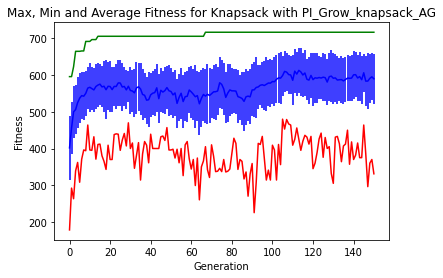

In [7]:
x = np.arange(MAX_GENERATIONS+1)
avgArray = np.array(avgListFitness)
stdArray = np.array(stdListFitness)
minArray = np.array(minListFitness)
maxArray = np.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title(
    f'Max, Min and Average Fitness for Knapsack with {pop_init_method.__name__}')
plt.errorbar(x, -avgArray.mean(0), yerr=-stdArray.mean(0),
                label="Average", color="Blue")
plt.errorbar(x, -minArray.mean(0), yerr=-
                minArray.std(0), label="Best", color="Green")
plt.errorbar(x, -maxArray.mean(0), yerr=-
                maxArray.std(0), label="Worst", color="Red")
# plt.savefig(f"{pop_init_method.__name__}.png")
print(f"Best Fitness Achieved: {np.max(-minArray)}")

In [ ]:
x = np.arange(MAX_GENERATIONS+1)
avgArray = np.array(avgListFitness)
stdArray = np.array(stdListFitness)
minArray = np.array(minListFitness)
maxArray = np.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title(
    f'Max, Min and Average Fitness for Knapsack with {pop_init_method.__name__}')
plt.errorbar(x, -avgArray.mean(0), yerr=-stdArray.mean(0),
                label="Average", color="Blue")
plt.errorbar(x, -minArray.mean(0), yerr=-
                minArray.std(0), label="Best", color="Green")
plt.errorbar(x, -maxArray.mean(0), yerr=-
                maxArray.std(0), label="Worst", color="Red")
# plt.savefig(f"{pop_init_method.__name__}.png")
print(f"Best Fitness Achieved: {np.max(-minArray)}")